In [ ]:
import requests
from urllib.parse import urlencode
import pandahouse as ph
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Задание 1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### **1.2 Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

* `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
* `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
* `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента.

* **А** - контрольная (базовая механика оплаты услуг на сайте)
* **B** - целевая (новая механика оплаты услуг на сайте)

### 1.3 Исследование данных

Загрузим данные и посмотрим их характеристики:

In [ ]:
# загрузим файл Проект_2_groups.csv по ссылке

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/JdoH-IrGfCM7Vg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
groups = pd.read_csv(download_url, sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [ ]:
print(f'Количество строк: {groups.shape[0]}')
print(f'Количество уникальных id: {groups.id.nunique()}')
print(f'Количество уникальных групп: {groups.grp.nunique()}')
print(f'Количество пропущенных значений в колонке id: {groups.isna().sum().id}')
print(f'Количество пропущенных значений в колонке group: {groups.isna().sum().grp}')
print(f'Количество пользователей в группе А: {groups[groups["grp"] == "A"].id.count()}')
print(f'Количество пользователей в группе В: {groups[groups["grp"] == "B"].id.count()}')

Количество строк: 74484
Количество уникальных id: 74484
Количество уникальных групп: 2
Количество пропущенных значений в колонке id: 0
Количество пропущенных значений в колонке group: 0
Количество пользователей в группе А: 14671
Количество пользователей в группе В: 59813


Как видно, количество уникальных пользователей совпадает с количеством записей, а значит дубликатов нет. Группа В по численности в 4 раза больше группы А.

In [ ]:
# загрузим файл Проект_2_group_add.csv по ссылке

public_key = 'https://disk.yandex.ru/d/qY-v6oiKel6mzg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
group_add = pd.read_csv(download_url, sep=',')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [ ]:
print(f'Количество строк: {group_add.shape[0]}')
print(f'Количество уникальных id: {group_add.id.nunique()}')
print(f'Количество уникальных групп: {group_add.grp.nunique()}')
print(f'Количество пропущенных значений в колонке id: {group_add.isna().sum().id}')
print(f'Количество пропущенных значений в колонке group: {group_add.isna().sum().grp}')
print(f'Количество пользователей в группе А: {group_add[group_add["grp"] == "A"].id.count()}')
print(f'Количество пользователей в группе В: {group_add[group_add["grp"] == "B"].id.count()}')

Количество строк: 92
Количество уникальных id: 92
Количество уникальных групп: 2
Количество пропущенных значений в колонке id: 0
Количество пропущенных значений в колонке group: 0
Количество пользователей в группе А: 22
Количество пользователей в группе В: 70


In [ ]:
# как видно, в новом присланном файле нет пользователей, которые уже были в первом файле groups

groups.merge(group_add, on='id')

,id,grp_x,grp_y


In [ ]:
# объединим оба датафрейма для более удобной работы

all_groups = pd.concat([groups, group_add], ignore_index=True)
all_groups.shape

(74576, 2)

In [ ]:
# загрузим файлПроект_2_active_studs.csv по ссылке

public_key = 'https://disk.yandex.ru/d/HcUAu8klTwSCDg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
active_studs = pd.read_csv(download_url, sep=';')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [ ]:
print(f'Количество строк: {active_studs.shape[0]}')
print(f'Количество уникальных id: {active_studs.student_id.nunique()}')
print(f'Количество пропущенных значений в колонке group: {active_studs.isna().sum().student_id}')

Количество строк: 8341
Количество уникальных id: 8341
Количество пропущенных значений в колонке group: 0


In [ ]:
# добавим столбец с признаком "1" для активных пользователей

active_studs['active_user'] = '1'

In [ ]:
# загрузим файл Проект_2_checks.csv по ссылке

public_key = 'https://disk.yandex.ru/d/90ev2ZpQcVHRLQ'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
checks = pd.read_csv(download_url, sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [ ]:
print(f'Количество строк: {checks.shape[0]}')
print(f'Количество уникальных id: {checks.student_id.nunique()}')
print(f'Количество пропущенных значений в колонке group: {checks.isna().sum().student_id}')
print(f'Количество пропущенных значений в колонке group: {checks.isna().sum().rev}')
print(f'Минимальная сумма оплаты: {checks.rev.min()}')
print(f'Максимальная сумма оплаты: {checks.rev.max()}')
print(f'Самая часто встречающаяся сумма: {checks.rev.mode()[0]}')

Количество строк: 541
Количество уникальных id: 541
Количество пропущенных значений в колонке group: 0
Количество пропущенных значений в колонке group: 0
Минимальная сумма оплаты: 199.0
Максимальная сумма оплаты: 4650.0
Самая часто встречающаяся сумма: 1900.0


In [ ]:
# добавим столбец с признаком "1" для оплативших пользователей

checks['paid_user'] = '1'

In [ ]:
# переименовываем колонки в df groups

all_groups = groups.rename(columns={'id': 'student_id', 'grp': 'group'})

Посмотрим на суммы, которые оплачивали пользователи:

In [ ]:
checks.groupby('rev', as_index=False) \
    .agg({'student_id': 'count'})\
    .sort_values('student_id', ascending=False)

,rev,student_id
24,1900.0000,97
1,290.0000,94
8,690.0000,78
0,199.0000,46
13,990.0000,41
25,1900.0001,36
10,840.0000,27
16,1140.0000,25
4,580.0000,15
5,590.0000,11


Можно заметить странную сумму в 1900.0001 руб, коорая встречается 36 раз.

Для простоты работы объединим все данные в одну таблицу:

In [ ]:
full_info_df = all_groups.merge(checks, on='student_id', how='left').fillna(0) \
                         .merge(active_studs, on='student_id', how='left', ).fillna('0')

full_info_df.head()

,student_id,group,rev,paid_user,active_user
0,1489,B,0.0,0,0
1,1627,A,990.0,1,1
2,1768,B,0.0,0,0
3,1783,B,0.0,0,0
4,1794,A,0.0,0,0


Посмотрим, есть ли пользователи, которые совершили оплату, но при этом не являются активными:

In [ ]:
full_info_df.query('active_user == "0" and rev != 0') \
            .agg({'student_id': 'count'}) \

student_id    149
dtype: int64

Видно, что такие пользователи есть и их 149 человек.

Посмотрим на распределение оплат по группам:

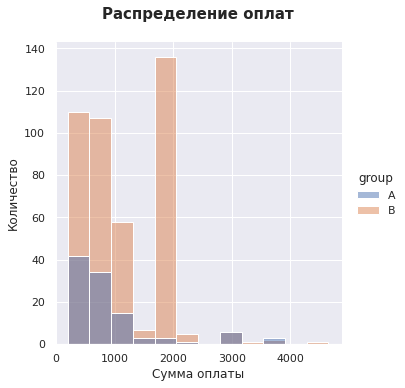

In [ ]:
ax_sum = sns.displot(data=full_info_df.query('rev>0'), x='rev', hue='group')
plt.ylabel("Количество")
plt.xlabel("Сумма оплаты")
plt.title("Распределение оплат\n", fontsize=15, fontweight = 'bold')
plt.show()

Оплаты в группах распределены не нормальным образом, также присутствуют выбросы. Так же видно, что странная сумма в 1900.0001 руб встречается только в группе В. Точно нельзя сказать, почему такая сумма могла возникнуть, возможно,клиенты пользовались промокодом или проводилась какая-то акция или, например, новая механика оплаты дала сбой (что могло бы объяснить наличие таких оплат только в группе В).

In [ ]:
full_info_sum = full_info_df.query('active_user == "1" and rev != 0') \
                            .groupby('group', as_index=False) \
                            .agg({'rev': 'sum', 'student_id': 'count'})
full_info_sum

,group,rev,student_id
0,A,72820.0000,78
1,B,393074.0035,313


Как можно видеть, из 541 пользователей, совершивших оплату, активных - 391 чел. в обеих группах. Нам интересны именно они, поэтому оставим только таких пользователей и создадим датафрейм activity_df_final.

In [ ]:
activity_df_final = full_info_df.query('rev > 0 and active_user == "1"')
activity_df_final.head()

,student_id,group,rev,paid_user,active_user
1,1627,A,990.0000,1,1
220,100300,B,990.0000,1,1
320,108270,B,290.0000,1,1
3779,264473,B,1900.0001,1,1
4187,274352,B,690.0000,1,1


В ходе предварительного анализе было выяснено:

Во всех трёх датафреймах (groups, groups_add, active_studs) процентное соотношение пользователей в группах А и B примерно одинаковое. Отметим, что в контрольной группе количество пользователей намного меньше.
* Общее количество уникальных пользователей - 74576.
* Количество пользователей, которые совершили оплату в дни проведения эксперимента - 541.

Наибольшее количество пользователей совершили оплату на сумму 1900р. Но 149 пользователей, совершивших оплату, не захоидили на платформу во время проведения эксперимента. Так как дополнительной информации нет, то причины могут быть разными, например автоматические списания (подписка), ошибка при проведении платежа или сбой в данных. Выделяется сумма 1900.0001, она тоже выглядит как какой-то сбой. Так как у нас нет возможности узнать реальные причины этих аномалий, было решено убрать их из результирующего датафрейма.

### 1.4 Выбор метрик

У нас нет данных о длительности проведения теста, поэтому логично исключить метрики, завязанные на времени (напр., WAU, LTV и т.д.). Так как основная цель это увеличить доход с помощью новой механики оплаты, то нам интересно посмотреть на различие в факте оплаты и сумме оплат в двух группах, если такие различия есть. Поэтому для анализа возьмем две метрики CR и ARPPU. СR покажет изменилось ли количество пользователей, совершивших оплату после внедрения новой механике оплаты, а ARPPU покажет увеличился ли доход с активного платящего пользователя.

Перед выбором стат.теста проведем проверку на нормальность распределения (тест Шапиро-Уилка) и на гомогенность дисперсии (тест Левена).

Обозначим гипотезу и альтернативу:

* H0 = распределение нормальное
* H1 = распределение отлично от нормального

In [ ]:
# проверка на нормальность группы A

res = stats.shapiro(activity_df_final.query('group =="A"').rev)
p_value = res.pvalue
alpha = 0.05

if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем принять нулевую гипотезу 
p-value =  1.4986822893803264e-10


In [ ]:
# проверка на нормальность группы В

res = stats.shapiro(activity_df_final.query('group =="B"').rev)
p_value = res.pvalue
alpha = 0.05

if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем принять нулевую гипотезу 
p-value =  1.756778758085431e-16


Распределения в обеих группах отличаются от нормального. Проверим гомогенность дисперсии в группах.

Обозначим гипотезу и альтернативу:

* H0 = дисперсии в двух группах гомогенны
* H1 = дисперсии не гомогенны

In [ ]:
res = stats.levene(activity_df_final.query('group == "A"').rev,
                    activity_df_final.query('group == "B"').rev, center='median')
p_value = res.pvalue
alpha = 0.05

if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем отклонить нулевую гипотезу 
p-value =  0.08123509393501775


Так как p-value > 0.05, то принимаем нулевую гипотезу - дисперсии групп одинаковы.

Хотя распределение групп и отличается от нормального, но выборка достаточно большая и дисперсии групп одинаковы, поэтому для сравнения ARPPU в двух группах мы можем использовать t-критерий. Для сравнения CR будем использовать Хи-квадрат Пирсона, т.к он позволяет сравнить отношения количества успеха к неуспехам в двух таблицах.

#### 1. Метрика ARPPU

In [ ]:
ARPPU_A = (full_info_sum.rev[0] / full_info_sum.student_id[0]).round(2)
ARPPU_A

933.59

In [ ]:
ARPPU_B = (full_info_sum.rev[1] / full_info_sum.student_id[1]).round(2)
ARPPU_B

1255.83

Обозначим гипотезу и альтернативу:

* H0 = средние в двух группах не различаются
* H1 = средние различны

In [ ]:
res = stats.ttest_ind(activity_df_final.query('group == "A"').rev,
                        activity_df_final.query('group == "B"').rev)
p_value = res.pvalue
alpha = 0.05

if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем принять нулевую гипотезу 
p-value =  0.001999178025210522


Так как p-value < 0.05, то нулевую гипотезу отклоняем, следовательно можно говорить о том, что средний доход в расчёте на одного платящего пользователя в группе В статистически значимо выше.

#### 2. CR

Построим таблицу сопряженности:

In [ ]:
# оставим только активных пользователей

full_info_df = full_info_df.query('active_user == "1"')

In [ ]:
crosstab = pd.crosstab(full_info_df.group, full_info_df.paid_user)
crosstab

paid_user,0,1
group,,
A,1457,78
B,6480,313


Обозначим гипотезу и альтернативу:

* H0 = Конверсии в двух группах одинаковы
* H1 = Есть значимое различие в конверсиях

In [ ]:
stat, p_value, dof, expected_fred = chi2_contingency(crosstab)

alpha = 0.05

if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем отклонить нулевую гипотезу 
p-value =  0.46803677583199144


Так как p-value больше 0,05 мы не имеем достаточных оснований отклонить нулевую гипотезу, следовательно, статистически значимых различий в CR между пользователями группы А и группы В нет.

### 1.5 Вывод

При формулировании выводов и, как следствие, принятия решения о запуске новой механике на всех пользователей необходимо обратить внимание на следующие моменты:
1. Большое различие в численности тестовой и контрольной групп. Необходимо понять из-за чего так получилось: такие группы изначально были заложены в дизайне эксперимента, это ошибка системы сплитования, ошибка системы логирования или есть какие-то другие объяснения.
2. Наличие оплат на сумму 1900.0001 руб в тестовой группе. Так же необходимо разобраться, что это и является ли это ошибкой.
3. Наличие 149 пользователей, совершивших платеж, но не заходивших на сайт. Тут тоже нужно понять, были ли это например автосписания платежей или какая-то ошибка.

Несмотря на то, что у нас недостаточно данных, чтобы ответить на эти вопросы, по результатам теста можно сделать следующие выводы:
* Статистически значимых различий в CR между группами не выявлено
* ARPPU вырос в тестовой группе, изменения статистически значимы

Учитывая все выше сказанное, я бы рекомендовала раскатывать новую механику на всех пользователей, но после изучения отмеченных выше моментов.

## Задание 2. SQL

### **2.1 Очень усердные ученики.**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Дана таблица default.peas.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

 Дана таблицы:
_default.peas:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|timesst||timestamp||Время решения карточки|
|correct||bool||Правильно ли решена горошина?|
|subject||text||Дисциплина в которой находится горошина|


\
_default.studs:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|test_grp||text||Метка ученика в данном эксперименте|


\
_default.final_project_check:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|saletime||timestamp||Время покупки|
|money||int||Цена, по которой приобрели данный курс|
|subject||text||Дисциплина в которой находится горошина|

In [ ]:
connection = dict(database='default',
                  host='http://clickhouse.lab.karpov.courses:80',
                  user='student',
                  password='dpo_python_2020')

In [ ]:
# Посмотрим на данные default.peas

query = """
SELECT st_id
      ,timest::DATE as date
      ,correct
      ,subject
FROM default.peas
ORDER BY date
"""
peas = ph.read_clickhouse(query, connection=connection)
peas.head()

,st_id,date,correct,subject
0,100379,2021-10-30,1,Theory of probability
1,100379,2021-10-30,0,Vizualization
2,100379,2021-10-30,1,Theory of probability
3,100379,2021-10-30,1,Vizualization
4,100379,2021-10-30,1,Theory of probability


In [ ]:
print(f'Количество уникальных предметов: {peas.subject.nunique()}')
print(f'Количество уникальных студентов: {peas.st_id.nunique()}')
print(f'Количество правильно решенных горошин: {peas.query("correct == 0").st_id.count()}')
print(f'Количество неправильно решенных горошин: {peas.query("correct == 1").st_id.count()}')
print(f'Минимальная дата: {peas.date.min()}, максимальная дата {peas.date.max()}')

Количество уникальных предметов: 5
Количество уникальных студентов: 308
Количество правильно решенных горошин: 6481
Количество неправильно решенных горошин: 6764
Минимальная дата: 2021-10-30 00:00:00, максимальная дата 2021-10-31 00:00:00


In [ ]:
query_1 = """
SELECT
  COUNT(DISTINCT st_id) as count_success_id
FROM(
      SELECT st_id
            ,COUNT(correct) as sum_correct
      FROM
          default.peas
      WHERE correct = 1
      GROUP BY st_id
      HAVING sum_correct >= 20)
"""
result = ph.read_clickhouse(query_1, connection=connection)
result

,count_success_id
0,136


#### Ответ приведен в датафрейме `result`

### **2.2 Оптимизация воронки**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU
* ARPAU
* CR в покупку
* СR активного пользователя в покупку
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [ ]:
# Посмотрим на данные default.studs

query_2 = """
SELECT *
FROM default.studs
LIMIT 5
"""
studs = ph.read_clickhouse(query_2, connection=connection)
studs

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [ ]:
# Посмотрим на данные default.final_project_check

query_3 = """
SELECT st_id
        ,sale_time::DATE as date
        ,money
        ,subject
FROM default.final_project_check
LIMIT 5
"""
final_project = ph.read_clickhouse(query_3, connection=connection)
final_project

,st_id,date,money,subject
0,101432,2021-10-31,85000,Math
1,101432,2021-10-31,65000,Vizualization
2,104885,2021-10-30,65000,Vizualization
3,104885,2021-10-30,75000,Statistics
4,106464,2021-10-31,85000,Math


In [ ]:
query_4 = """
SELECT test_grp as group
      ,round(SUM(t2.money) / uniqExact(t1.st_id), 2) as ARPU
      ,round(SUMIf(t2.money, t3.active > 10) / uniqIf(t1.st_id,  t3.active > 10), 2) as ARPAU
      ,round(uniqIf(t1.st_id, t2.money > 0) / uniqExact(t1.st_id) * 100, 2) AS CR
      ,round(uniqIf(t1.st_id, t2.money > 0 and t3.active > 10) / uniqIf(t1.st_id, t3.active > 10)* 100, 2) AS CR_Active
      ,round(uniqIf(t1.st_id, t2.money > 0 and t3.math_active >= 2 and t2.subject = 'Math') /
                                                  uniqIf(t1.st_id, t3.math_active >= 2) * 100, 2) AS CR_math
FROM default.studs t1
LEFT JOIN default.final_project_check t2
    ON t1.st_id = t2.st_id
LEFT JOIN (SELECT st_id
                ,SUM(correct) as active
                ,SUMIf(correct, subject = 'Math') as math_active
            FROM default.peas
            GROUP BY st_id) t3
    ON t1.st_id = t3.st_id
GROUP BY test_grp
"""


result_2 = ph.read_clickhouse(query_4, connection=connection)
result_2

,group,ARPU,ARPAU,CR,CR_Active,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


#### Ответ приведен в датафрейме `result_2`

## Задание 3. Python

### **3.1**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [ ]:
def calculate_metrics(groups, group_add, active_studs, checks):
    '''Добавляет новые колонки с признаком активного и платящего пользователя,
    Мерджит датафреймы с пользователями и считает необходимые метрики'''

    active_studs['activity'] = 1
    checks['is_paid'] = 1

    all_groups = pd.concat([groups, group_add]).rename(columns={'grp': 'group', 'id':'student_id'})
    full_info_df = all_groups.merge(checks, on='student_id', how='left').fillna(0) \
                             .merge(active_studs, on='student_id', how='left').fillna(0)

    full_info_active = full_info_df.query('activity == 1')
    metrics = full_info_active.groupby('group', as_index=False) \
                      .agg({'student_id': 'count', 'is_paid': ['sum', 'mean'], 'rev': ['sum', 'mean']})

    metrics.columns = ['group', 'students', 'checks', 'CR', 'rev', 'ARPPU']
    metrics['CR'] = round(metrics['CR'] * 100, 1)
    metrics['ARPPU'] = round(metrics['rev'] / metrics['checks'], 1)
    metrics['ARPU'] = round(metrics['rev'] / metrics['students'], 1)

    return metrics

In [ ]:
df = calculate_metrics(groups, group_add, active_studs, checks)
df

,group,students,checks,CR,rev,ARPPU,ARPU
0,A,1538,78.0,5.1,72820.0000,933.6,47.3
1,B,6803,314.0,4.6,394974.0035,1257.9,58.1


### **3.2**
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
def plotting(df):
    '''Функция строит графики по подсчитанным метрикам'''

    sns.set_theme(style = 'darkgrid')
    fig, axs = plt.subplots(ncols = 3, figsize = (20, 9))

    sns.barplot(x = "group", y = "CR", data = df, ax = axs[0]).set_title('CR', fontsize=12, fontweight = 'bold')
    sns.barplot(x = "group", y = "ARPU", data = df, ax = axs[1]).set_title('ARPU', fontsize=12, fontweight = 'bold')
    sns.barplot(x = "group", y = "ARPPU", data = df, ax = axs[2]).set_title('ARPPU', fontsize=12, fontweight = 'bold')
    fig.show()

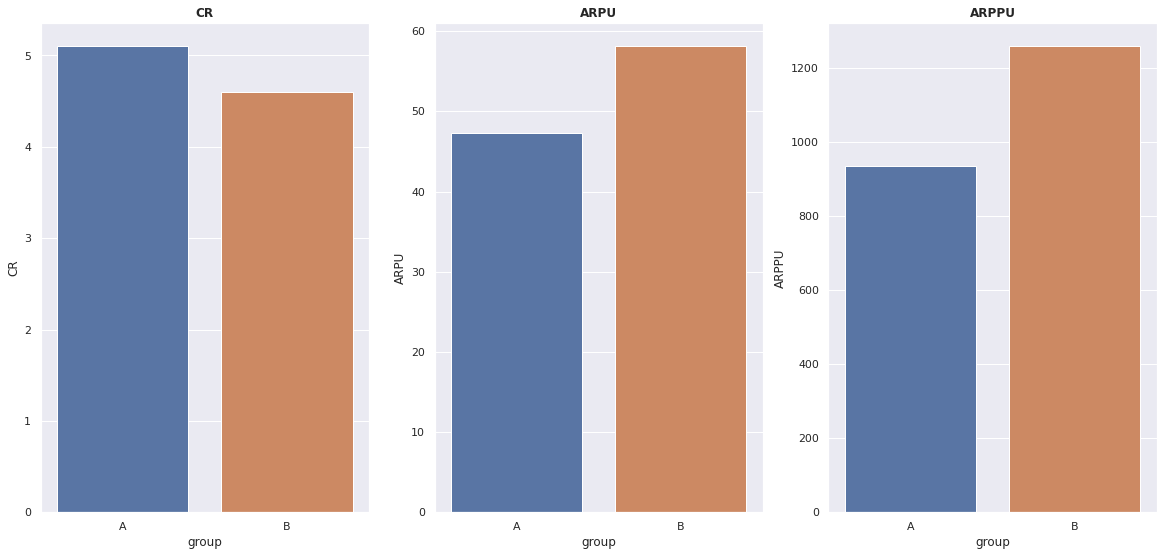

In [ ]:
plotting(df)